# Imports

In [9]:
# Remember to login to wandb!
import sys
import os 

# Add the test directory to sys.path



# Standard library imports
import importlib
import gc
import copy

# Third-party imports
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import einops
import matplotlib.pyplot as plt

parent_dir = os.path.expanduser('..')
sys.path.append(parent_dir)


from transformers import GPT2Model, GPT2Config, GPT2Tokenizer
from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate
import wandb

# Reload modules using importlib
importlib.reload(importlib.import_module('eigenestimation.eigenhora'))
importlib.reload(importlib.import_module('eigenestimation.loss'))
importlib.reload(importlib.import_module('eigenestimation.train'))
importlib.reload(importlib.import_module('evaluation.examples'))
importlib.reload(importlib.import_module('evaluation.networks'))

importlib.reload(importlib.import_module('toy_models.tms'))
importlib.reload(importlib.import_module('eigenestimation.utils'))



from eigenestimation.eigenhora import EigenHora
from eigenestimation import loss
from eigenestimation.train import Train
from evaluation.examples import TopActivatingSamples 
from evaluation.networks import DrawNeuralNetwork

from toy_models import tms
from eigenestimation.utils import TransformDataLoader, DeleteParams, RetrieveWandBArtifact

device = 'cuda'



# TMS

/root/.eigenestimation/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


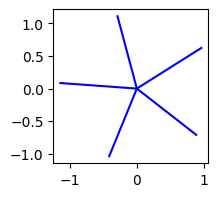

In [10]:
# Load TMS model
tms_model = tms.AutoencoderSymmetric(input_dim=5, hidden_dim=2)
tms_model.load_state_dict(torch.load(f"{parent_dir}/models/tms_model.pth", weights_only=True))

# Plot TMS representations.
en = copy.deepcopy(tms_model.W_in).detach().cpu().numpy().transpose()

plt.figure(figsize=(2,2))
for i in range(en.shape[1]):
  plt.plot([0, en[0,i]], [0,en[1,i]], 'b-')
plt.show()

# Parallel TMS


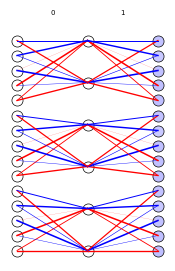

In [11]:
# Load TMS model
tms_model_p = tms.AutoencoderParallel(input_dim=5, hidden_dim=2, n_networks=3)
tms_model_p.load_state_dict(torch.load(f"{parent_dir}/models/tms_model_parallel.pth", weights_only=True))

model_params = dict(tms_model_p.named_parameters())
weights = {k:v for k,v in model_params.items() if 'b' not in k}
weights = {str(i):v.transpose(0,1) for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'b' in k}
biases = {str(i+1):v for i,v in enumerate(biases.values())}

f = DrawNeuralNetwork(weights, biases)

In [16]:
def model0(y):
    return torch.zeros_like(y)

n_networks = 3

n_features = 5

n_datapoints = 3*4096
X_tms_p, _, _= tms.GenerateTMSDataParallel(
    num_features=n_features, num_datapoints=n_datapoints,
    sparsity=.05,
    batch_size=16,
    n_networks=n_networks)

X_tms_p = X_tms_p.to(device)

hora_features = 15
hora_rank = 1
eigenmodel = EigenHora(tms_model_p.to(device), model0, loss.MSELoss(), hora_features, hora_rank, device=device).to(device)


dataloader = TransformDataLoader(X_tms_p, batch_size=32, transform_fn=eigenmodel.compute_jacobian)


eval_dataloader = TransformDataLoader(X_tms_p[:1000], batch_size=32, transform_fn=eigenmodel.compute_jacobian)
Train(eigenmodel, dataloader, lr=.001, n_epochs=50, L0_penalty=.01, device=device, project_name='eigenestimation', run_name='tms_model_parallel',
      eval_fns={TopActivatingSamples:[3]}, eval_dataloader=eval_dataloader)    

wandb: Currently logged in as: brianna-chrisman (brianna-chrisman-2024). Use `wandb login --relogin` to force relogin


Epoch 0 : 5.128,  Reconstruction Loss: 5.107,  Sparsity Loss: 2.167
Epoch 5 : 2.067,  Reconstruction Loss: 2.032,  Sparsity Loss: 3.502
Epoch 10 : 1.448,  Reconstruction Loss: 1.420,  Sparsity Loss: 2.811
Epoch 15 : 1.364,  Reconstruction Loss: 1.341,  Sparsity Loss: 2.314
Epoch 20 : 1.168,  Reconstruction Loss: 1.147,  Sparsity Loss: 2.089
Epoch 25 : 1.162,  Reconstruction Loss: 1.142,  Sparsity Loss: 2.085
Epoch 30 : 1.166,  Reconstruction Loss: 1.145,  Sparsity Loss: 2.092
Epoch 35 : 1.164,  Reconstruction Loss: 1.143,  Sparsity Loss: 2.090
Epoch 40 : 1.168,  Reconstruction Loss: 1.148,  Sparsity Loss: 2.089
Epoch 45 : 1.171,  Reconstruction Loss: 1.150,  Sparsity Loss: 2.094
evaluating...
TopActivatingSamples


reconstruction_loss,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparsity_loss,▁▇██▇▆▅▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss,█▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,1.14574
sparsity_loss,2.08939
total_loss,1.16663


In [17]:
top_samples = RetrieveWandBArtifact(project_path="brianna-chrisman-2024/Eigenestimation/eigenestimation_tms_model_parallel", metric_name="TopActivatingSamples")



eigenmodel = EigenHora(tms_model_p, None, loss.MSELoss(), len(top_samples), 1, device=device).to(device)
eigenmodel.low_rank = RetrieveWandBArtifact(project_path="brianna-chrisman-2024/Eigenestimation/eigenestimation_tms_model_parallel", metric_name="subnetworks")

wandb:   1 of 1 files downloaded.  


/root/eigenestimation/notebooks/artifacts/eigenestimation_tms_model_parallel_TopActivatingSamples:v19


wandb:   1 of 1 files downloaded.  


/root/eigenestimation/notebooks/artifacts/eigenestimation_tms_model_parallel_subnetworks:v15


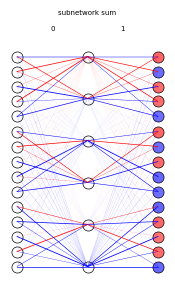

In [18]:
model_params = eigenmodel.reconstruct_network()
weights = {k:v.transpose(0,1) for k,v in model_params.items() if 'b' not in k}
weights = {str(i):v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'b' in k}
biases = {str(i+1):v for i,v in enumerate(biases.values())}


figs = DrawNeuralNetwork(weights, biases, title='subnetwork sum')

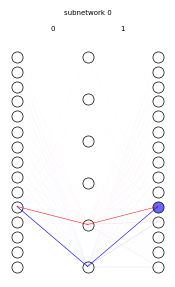

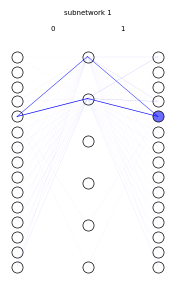

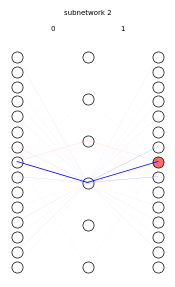

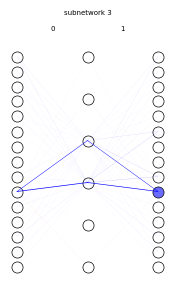

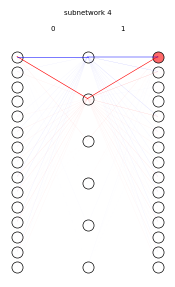

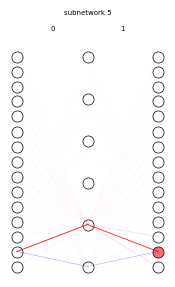

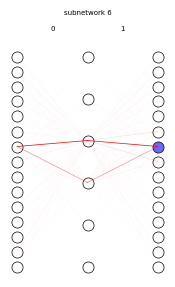

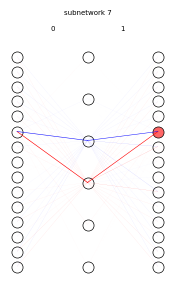

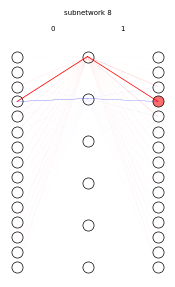

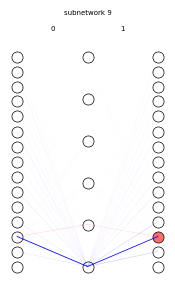

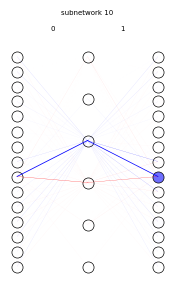

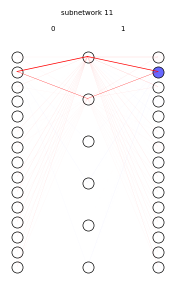

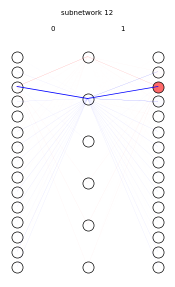

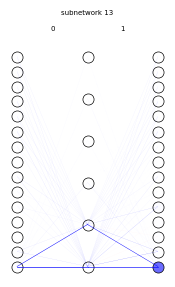

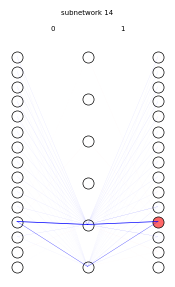

In [19]:
figs = []

for i, network in enumerate(eigenmodel.construct_subnetworks()):
    weights = {k:v.transpose(0,1) for k,v in network.items() if 'b' not in k}
    weights = {str(i):v for i,v in enumerate(weights.values())}

    biases = {k:v for k,v in network.items() if 'b' in k}
    biases = {str(i+1):v for i,v in enumerate(biases.values())}

    
    figs.append(DrawNeuralNetwork(weights, biases, title=f'subnetwork {i}'))